In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from imblearn.over_sampling import RandomOverSampler
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import tensorflow as tf
from sklearn.linear_model import LinearRegression

# Dataset
Ilmi, M. F. (2022). Spotify App Reviews 2022. Kaggle. https://www.kaggle.com/datasets/mfaaris/spotify-app-reviews-2022/

License: Attribution-NonCommercial 4.0 International (CC BY-NC 4.0)

In [2]:
# I'm using Google Colab for the codes
# Read the csv file from the website source above on your personal directory

from google.colab import drive
drive.mount('/content/drive')
file_path = '/content/drive/MyDrive/Colab/P2: Spotify Reviews/reviews.csv' # modify as you need


df = pd.read_csv(file_path)
df = df.sample(frac=1).reset_index(drop=True) # Randomize before previewing the dataset
df.head(10)

Mounted at /content/drive


,Time_submitted,Review,Rating,Total_thumbsup,Reply
0,2022-04-16 21:42:15,It's OK. I think I like pandora better. But I'...,4,0,NaN
1,2022-03-25 09:49:36,Spotify is the most convenient music streaming...,5,0,NaN
2,2022-06-06 11:49:46,It's annoying how I can't play the music I lik...,2,0,NaN
3,2022-05-20 11:08:13,This update change the spotify music start app 😂🙂,4,0,NaN
4,2022-06-30 02:13:49,Spotify is not functioning properly at all. Fo...,1,1,NaN
5,2022-05-11 14:34:20,MAKE THE NAVIGATION BAR TRANSPARENT & ADD ROUN...,1,0,Hi there! Thanks for sharing your thoughts. We...
6,2022-04-16 00:51:00,My favorite feature is the operating while in ...,5,0,NaN
7,2022-03-21 13:56:10,The free version absolutely has me wanting to ...,1,1,NaN
8,2022-06-23 10:27:25,Changed my comment since last time since more ...,3,9,NaN
9,2022-04-20 09:07:26,"I love spotify, but the app has been driving m...",3,7,NaN


In [3]:
df['Date'] = pd.to_datetime(df['Time_submitted']).dt.date

#To insert the 'Date' column as the first column
cols = list(df.columns)
cols = [cols[-1]] + cols[:-1]
df = df[cols]

df.head(10)

,Date,Time_submitted,Review,Rating,Total_thumbsup,Reply
0,2022-04-16,2022-04-16 21:42:15,It's OK. I think I like pandora better. But I'...,4,0,NaN
1,2022-03-25,2022-03-25 09:49:36,Spotify is the most convenient music streaming...,5,0,NaN
2,2022-06-06,2022-06-06 11:49:46,It's annoying how I can't play the music I lik...,2,0,NaN
3,2022-05-20,2022-05-20 11:08:13,This update change the spotify music start app 😂🙂,4,0,NaN
4,2022-06-30,2022-06-30 02:13:49,Spotify is not functioning properly at all. Fo...,1,1,NaN
5,2022-05-11,2022-05-11 14:34:20,MAKE THE NAVIGATION BAR TRANSPARENT & ADD ROUN...,1,0,Hi there! Thanks for sharing your thoughts. We...
6,2022-04-16,2022-04-16 00:51:00,My favorite feature is the operating while in ...,5,0,NaN
7,2022-03-21,2022-03-21 13:56:10,The free version absolutely has me wanting to ...,1,1,NaN
8,2022-06-23,2022-06-23 10:27:25,Changed my comment since last time since more ...,3,9,NaN
9,2022-04-20,2022-04-20 09:07:26,"I love spotify, but the app has been driving m...",3,7,NaN


# Quick EDA

In [4]:
# Count the rating frequency (how many 1-star reviews and 5-star reviews)
rating_counts = df['Rating'].value_counts()
rating_counts.index = rating_counts.index.astype(str) + "-star"
rating_counts

,count
Rating,
5-star,22095
1-star,17653
4-star,7842
2-star,7118
3-star,6886


In [5]:
# Adding percentage column beside the "count" column in rating_counts table
rating_shares = round((rating_counts / rating_counts.sum()) * 100,1)
rating_df = pd.DataFrame({'count': rating_counts, 'share': rating_shares})
rating_df


,count,share
Rating,,
5-star,22095,35.9
1-star,17653,28.7
4-star,7842,12.7
2-star,7118,11.6
3-star,6886,11.2


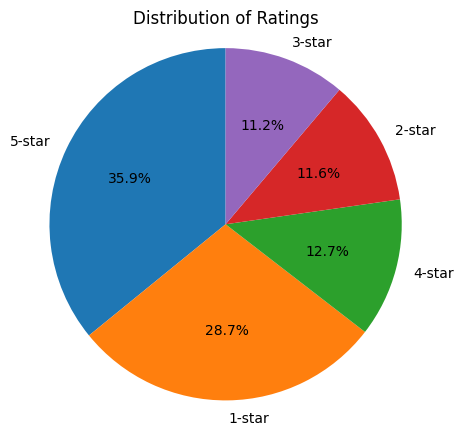

In [6]:
# Plot the ratings above using pie chart
plt.figure(figsize=(5, 5))
plt.pie(rating_counts, labels=rating_counts.index, autopct='%1.1f%%', startangle=90)
plt.title('Distribution of Ratings')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

In [7]:
# Provide the general statistics using describe() function from pandas:
df.describe().round(3)

,Rating,Total_thumbsup
count,61594.000,61594.000
mean,3.156,7.649
std,1.673,89.323
min,1.000,0.000
25%,1.000,0.000
50%,3.000,0.000
75%,5.000,1.000
max,5.000,8195.000


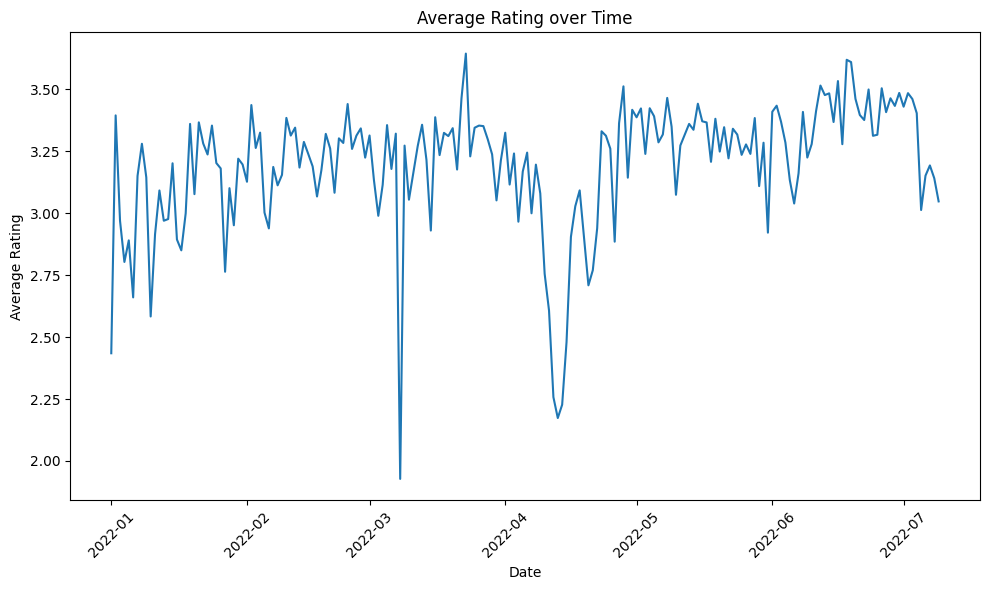

In [8]:
# aggregate the ratings using mean for each date, then plot using line chart
df['Time_submitted'] = pd.to_datetime(df['Time_submitted'])
daily_ratings = df.groupby(df['Date'])['Rating'].mean()

# Create the line chart
plt.figure(figsize=(10, 6))
plt.plot(daily_ratings.index, daily_ratings.values)
plt.xlabel('Date')
plt.ylabel('Average Rating')
plt.title('Average Rating over Time')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout() # Adjust layout to prevent labels from overlapping
plt.show()

# Preprocessing

## Finding the Outliers: Very-low aggregate ratings?
Getting know the overall reviews of some of the dates with aggregate ratings below 2.25

In [9]:
# Sort the avg rating values of each date
daily_ratings = daily_ratings.reset_index()
daily_ratings.sort_values(by = 'Rating', ascending=True)

,Date,Rating
66,2022-03-08,1.927457
102,2022-04-13,2.173252
103,2022-04-14,2.227048
101,2022-04-12,2.257697
0,2022-01-01,2.434783
...,...,...
162,2022-06-12,3.515815
166,2022-06-16,3.533958
169,2022-06-19,3.610577
168,2022-06-18,3.619870


In [10]:
# Preview the review data from March 8
df['Date'] = pd.to_datetime(df['Date'])
march8_reviews = df[df['Date'] == pd.to_datetime('2022-03-08')]
march8_reviews

,Date,Time_submitted,Review,Rating,Total_thumbsup,Reply
62,2022-03-08,2022-03-08 18:42:15,Seems like others are being logged out for no ...,1,1,NaN
63,2022-03-08,2022-03-08 18:33:05,It automatically signed me out my account. And...,2,0,NaN
117,2022-03-08,2022-03-08 18:59:07,"Disappointing, i tried 3 accounts, and it keep...",1,0,NaN
120,2022-03-08,2022-03-08 18:56:18,Today my app crashed few times and surprisingl...,2,1,NaN
205,2022-03-08,2022-03-08 19:20:32,The app logged me out of my account and now wi...,1,1,NaN
...,...,...,...,...,...,...
61457,2022-03-08,2022-03-08 19:54:53,Stop logging people out for no reason. Make an...,1,17,NaN
61459,2022-03-08,2022-03-08 18:23:50,Just tried to sign in after years of use and i...,1,1,NaN
61532,2022-03-08,2022-03-08 19:01:34,This app was great until the updates happened....,2,0,NaN
61574,2022-03-08,2022-03-08 18:35:53,It signed me out of my account this morning as...,3,2,NaN


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


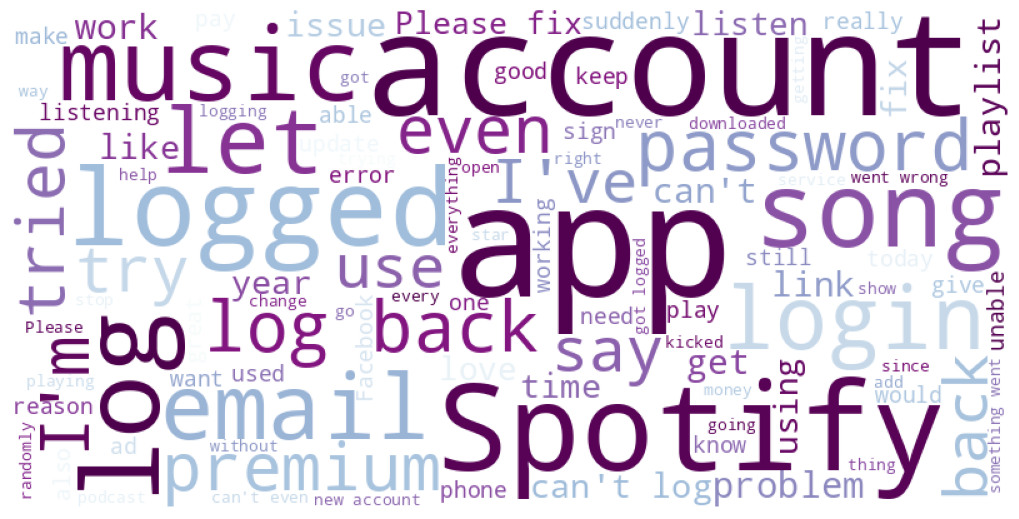

In [12]:
# Plot a word cloud for specific_date_reviews, take only keywords

# !pip install wordcloud # Download if not available
# nltk.download('stopwords') # Download if not available

import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud

# Generating the word cloud
text = " ".join(review for review in march8_reviews['Review']) # Generate by joining the texts first
english_stopwords = set(stopwords.words('english')) # Get English stopwords

wordcloud = WordCloud(
    width=800,
    height=400,
    background_color='white',
    stopwords=english_stopwords,
    max_words=100,
    colormap='BuPu_r'
).generate(text)

# Display the generated image:
plt.figure(figsize=(10,5), facecolor=None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

Apparently the spotify app could not be logged in even by the paid users on
March 8, 2022. Let's see for other dates (we'll take April 13 and April 14).

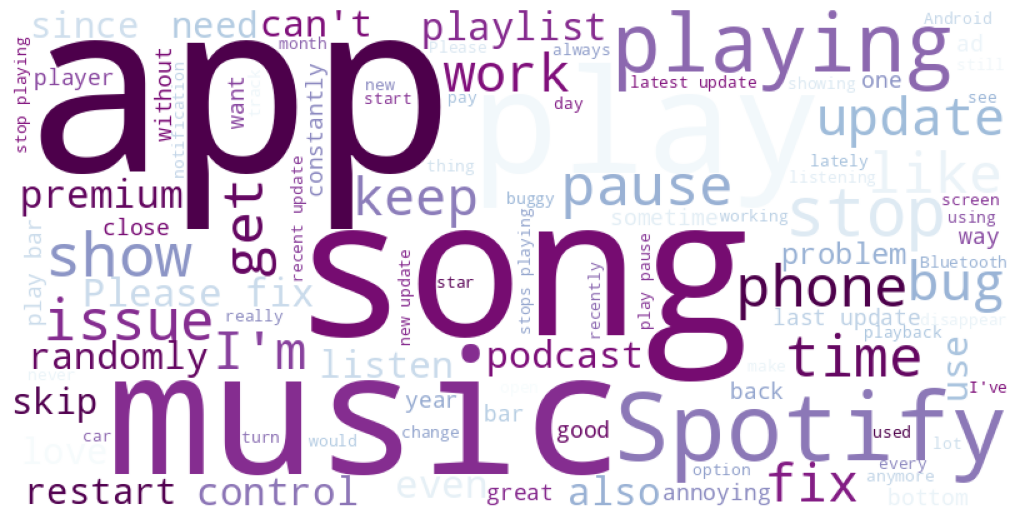

In [13]:
april_low_reviews = df[
    (df['Date'] == pd.to_datetime('2022-04-13')) |
    (df['Date'] == pd.to_datetime('2022-04-14'))]

# Generating the word cloud
text = " ".join(review for review in april_low_reviews['Review']) # Generate by joining the texts first

wordcloud = WordCloud(
    width=800,
    height=400,
    background_color='white',
    stopwords=english_stopwords,
    max_words=100,
    colormap='BuPu_r'
).generate(text)

# Display the generated image:
plt.figure(figsize=(10,5), facecolor=None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

I see. Most likely the spotify had some playback issues on April 13 and 14.

## Dropping the outliers
After we identified the date very-low aggregate scores above, we concluded that they were due to major technical errors in the app that had already been quickly fixed later. So we don't need to include them for later processes.

Before deprecating, let's see the z-score of each date, starting from the lowest aggregated ratings first.


In [88]:
# Add the zscore column
daily_ratings.loc[:, 'zscore'] = (daily_ratings['Rating'] - daily_ratings['Rating'].mean()) / daily_ratings['Rating'].std()

# Sort by rating and print the first 15
sorted_items = daily_ratings.sort_values(by='zscore', ascending=True)
sorted_items

,Date,Rating,zscore
66,2022-03-08,1.927457,-4.856403
102,2022-04-13,2.173252,-3.916333
103,2022-04-14,2.227048,-3.710584
101,2022-04-12,2.257697,-3.593367
0,2022-01-01,2.434783,-2.916083
...,...,...,...
162,2022-06-12,3.515815,1.218440
166,2022-06-16,3.533958,1.287829
169,2022-06-19,3.610577,1.580867
168,2022-06-18,3.619870,1.616411


Based on the table above, We'll deprecate reviews with dates that have the z-scores below -3, which means
- March 8
- April 12 to April 14

In [15]:
# Dates to drop
dates_to_drop = [pd.to_datetime('2022-03-08').date(),
                 pd.to_datetime('2022-04-12').date(),
                 pd.to_datetime('2022-04-13').date(),
                 pd.to_datetime('2022-04-14').date()]

# Drop rows where 'Date' is in dates_to_drop
df = df[~df['Date'].isin(dates_to_drop)]

<ipython-input-15-e254588d02dc>:8: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  df = df[~df['Date'].isin(dates_to_drop)]


Preview using pie chart after dropping the outlier dates:

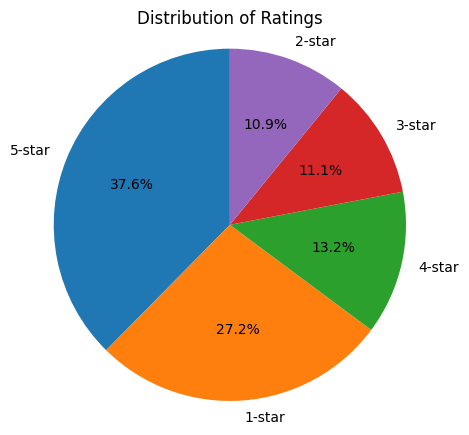

In [16]:
rating_counts = df['Rating'].value_counts()
rating_counts.index = rating_counts.index.astype(str) + "-star"

# Plot the ratings above using pie chart
plt.figure(figsize=(5, 5))
plt.pie(rating_counts, labels=rating_counts.index, autopct='%1.1f%%', startangle=90)
plt.title('Distribution of Ratings')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

We can see slight increase on the 5-star section and slight decrease on the 1-star section

# Applying Shifterator analysis

In [ ]:
# prompt: Apply shifterator analysis to compare 1-star ratings and 5-star ratings from the df table using the shifterator library
# !pip install shifterator --upgrade
import shifterator as sh
print(dir(sh))

# Prepare the data for Shifterator
one_star_reviews = df[df['Rating'] == 1]['Review'].tolist()
five_star_reviews = df[df['Rating'] == 5]['Review'].tolist()

In [ ]:
# drop some words based on english stop from one_star_reviews and five_star_reviews
nltk.download('stopwords')
english_stopwords = set(stopwords.words('english'))

# Function to remove stopwords from a list of strings
def remove_stopwords(text_list):
    return [" ".join([word for word in review.lower().split() if word not in english_stopwords])
            for review in text_list]

# Apply the function to your one_star_reviews and five_star_reviews lists
one_star_reviews = remove_stopwords(one_star_reviews)
five_star_reviews = remove_stopwords(five_star_reviews)

In [ ]:
# remove punctuations in one_star_reviews and five_star_reviews
import string

def remove_punctuation(text):
  translator = str.maketrans('', '', string.punctuation)
  return text.translate(translator)

one_star_reviews = [remove_punctuation(review) for review in one_star_reviews]
five_star_reviews = [remove_punctuation(review) for review in five_star_reviews]

In [77]:
# prompt: count the word frequency from one_star_review and five_star_review. Use dict type

from collections import defaultdict

def word_frequency(text_list):
    word_freq = defaultdict(int)
    for text in text_list:
        for word in text.split():
            word_freq[word] += 1
    return dict(word_freq)

one_star_freq = word_frequency(one_star_reviews)
five_star_freq = word_frequency(five_star_reviews)

print("One-star review word frequencies:", one_star_freq)
print("\nFive-star review word frequencies:", five_star_freq)

One-star review word frequencies: {'spotify': 4859, 'functioning': 21, 'properly': 238, 'all': 294, 'almost': 193, 'week': 175, 'keep': 560, 'getting': 609, 'something': 588, 'went': 186, 'wrong': 291, 'check': 71, 'internet': 655, 'connection': 534, 'try': 697, 'again': 474, 'anytime': 21, 'click': 354, 'go': 859, 'anywhere': 38, 'tried': 677, 'reinstalling': 142, 'looking': 138, 'issue': 626, 'up': 202, 'nothing': 529, 'fix': 1806, 'im': 2220, 'stuck': 150, 'using': 748, 'iheartradio': 6, 'cant': 3908, 'play': 4648, 'anything': 477, 'make': 693, 'navigation': 26, 'bar': 426, 'transparent': 2, 'add': 705, 'rounded': 3, 'corners': 4, 'cover': 10, 'arts': 1, 'songs': 5302, 'like': 2224, 'podcasts': 875, 'gradient': 1, 'playing': 2258, 'look': 175, 'one': 1515, 'ios': 36, 'free': 984, 'version': 631, 'absolutely': 222, 'wanting': 13, 'slice': 1, 'wristsits': 1, 'terrible': 461, 'superb': 3, 'please': 1322, 'easier': 36, 'find': 445, 'users': 241, 'follow': 26, 'always': 672, 'downloading

In [97]:
# Take the top 20 words from each dict (one_star_reviews, five_star_reviews)
import heapq

def top_n_words(freq_dict, n=50):
    return dict(heapq.nlargest(n, freq_dict.items(), key=lambda item: item[1]))

top_50_one_star = top_n_words(one_star_freq)
top_50_five_star = top_n_words(five_star_freq)

print("Top 50 words in one-star reviews:", top_50_one_star)
print("\nTop 50 words in five-star reviews:", top_50_five_star)

Top 50 words in one-star reviews: {'app': 10090, 'song': 5503, 'songs': 5302, 'spotify': 4859, 'music': 4723, 'play': 4648, 'cant': 3908, 'even': 3120, 'premium': 2950, 'listen': 2830, 'ads': 2807, 'playlist': 2340, 'want': 2314, 'playing': 2258, 'like': 2224, 'im': 2220, 'update': 2124, 'get': 1823, 'fix': 1806, 'time': 1682, 'every': 1607, 'use': 1548, 'one': 1515, 'it': 1453, 'phone': 1378, 'please': 1322, 'still': 1191, 'back': 1161, 'work': 1145, 'stop': 1096, 'pay': 1077, 'many': 1050, 'good': 1037, 'new': 1030, 'also': 994, 'free': 984, 'ive': 984, 'keeps': 978, 'plays': 948, 'really': 922, 'annoying': 886, 'would': 878, 'without': 876, 'podcasts': 875, 'way': 868, 'used': 860, 'go': 859, 'playlists': 845, 'shuffle': 829, 'skip': 825}

Top 50 words in five-star reviews: {'music': 12019, 'app': 10508, 'spotify': 7021, 'love': 5942, 'songs': 4059, 'great': 3965, 'best': 3671, 'good': 3514, 'listen': 2931, 'like': 2854, 'use': 2239, 'song': 2172, 'premium': 2034, 'easy': 1762, 'rea

In [101]:
# Find common words between one_star_reviews and five_star_reviews
common_words = set(top_50_one_star.keys()) & set(top_50_five_star.keys())
print(common_words)

{'premium', 'it', 'playlists', 'would', 'song', 'ads', 'listen', 'free', 'music', 'get', 'songs', 'ive', 'also', 'like', 'one', 'play', 'many', 'app', 'even', 'podcasts', 'every', 'new', 'really', 'im', 'good', 'time', 'spotify', 'want', 'use', 'playlist'}


In [103]:
# prompt: Drop the keys in "top_50_one_star" and "top_50_five_star" that are in "common_words"

# Drop common words from top_50_one_star and top_50_five_star
for word in common_words:
    if word in top_50_one_star:
        del top_50_one_star[word]
    if word in top_50_five_star:
        del top_50_five_star[word]

print("Updated top 50 words in one-star reviews:", top_50_one_star)
print("\nUpdated top 50 words in five-star reviews:", top_50_five_star)

Updated top 50 words in one-star reviews: {'cant': 3908, 'playing': 2258, 'update': 2124, 'fix': 1806, 'phone': 1378, 'please': 1322, 'still': 1191, 'back': 1161, 'work': 1145, 'stop': 1096, 'pay': 1077, 'keeps': 978, 'plays': 948, 'annoying': 886, 'without': 876, 'way': 868, 'used': 860, 'go': 859, 'shuffle': 829, 'skip': 825}

Updated top 50 words in five-star reviews: {'love': 5942, 'great': 3965, 'best': 3671, 'easy': 1762, 'listening': 1474, 'amazing': 1307, 'find': 1146, 'much': 1118, 'ever': 1027, 'better': 933, 'favorite': 920, 'using': 920, 'awesome': 907, 'quality': 891, 'enjoy': 879, 'years': 844, 'nice': 826, 'always': 825, 'experience': 794, 'thank': 772}


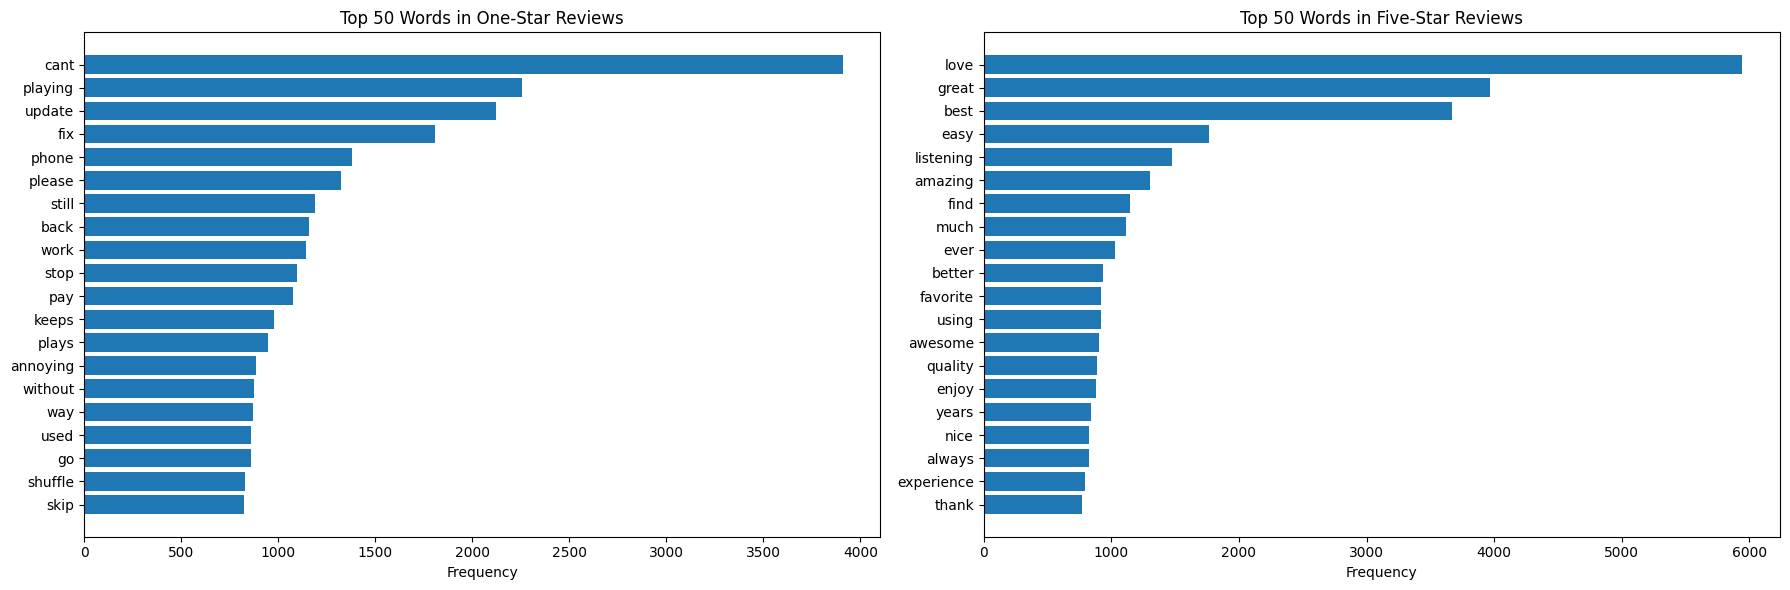

In [119]:
# plot top_50_one_star and top_50_five_star horizontally

# Extract words and frequencies for one-star reviews
one_star_words = list(top_50_one_star.keys())
one_star_freqs = list(top_50_one_star.values())

# Extract words and frequencies for five-star reviews
five_star_words = list(top_50_five_star.keys())
five_star_freqs = list(top_50_five_star.values())

plt.figure(figsize=(18, 6))  # Adjust figsize for one-star plot

plt.subplot(1, 2, 1)
plt.barh(one_star_words, one_star_freqs)
plt.xlabel("Frequency")
plt.title("Top 50 Words in One-Star Reviews")
plt.gca().invert_yaxis()

plt.subplot(1, 2, 2)
plt.barh(five_star_words, five_star_freqs)
plt.xlabel("Frequency")
plt.title("Top 50 Words in Five-Star Reviews")
plt.gca().invert_yaxis()

plt.tight_layout()
plt.show()
